# 🩺 AI-Driven Chest X-Ray Classification for COVID-19 and Pneumonia Detection
### Rashmitha Eri & Chadwick Kota  
**Course Project Submission**  
**Date:** April 14, 2025

---

This notebook presents our deep learning approach for classifying chest X-ray images into **COVID-19**, **Pneumonia**, and **Normal** categories.  
We implement and compare:
- A custom CNN for fast, interpretable predictions  
- A ResNet-50 model leveraging transfer learning  
- Grad-CAM visualizations to enhance interpretability  
- Internal and external validation for generalization


In [59]:
# Importing the PyTorch library
import torch

# Printing the current version of PyTorch being used
print("PyTorch version:", torch.__version__)

# Checking if a GPU is currently available and printing the result
print("GPU available:", torch.cuda.is_available())


PyTorch version: 2.6.0+cu124
GPU available: True


In [60]:
# Importing necessary libraries for system operations, randomness, numerical computations, and visualization
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Importing PyTorch utilities for dataset splitting and data loading
from torch.utils.data import random_split
import torch
from torch.utils.data import DataLoader, random_split

# Importing torchvision tools for datasets, transformations, and pre-trained models
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder

# Importing utility to get unique labels from scikit-learn
from sklearn.utils.multiclass import unique_labels

# Importing Path for handling filesystem paths
from pathlib import Path

# Importing additional PyTorch modules for model creation and optimization
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

# Checking if a GPU is available and setting the computing device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Defining a function that is setting seeds for all random number generators to ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)  # Setting seed for Python's random module
    np.random.seed(seed)  # Setting seed for NumPy
    torch.manual_seed(seed)  # Setting seed for PyTorch on CPU
    torch.cuda.manual_seed_all(seed)  # Setting seed for PyTorch on all available GPUs
    torch.backends.cudnn.deterministic = True  # Forcing cuDNN to use deterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disabling cuDNN benchmarking to maintain consistency

# Calling the seed-setting function
set_seed()


Using device: cuda


In [61]:
import torch.nn as nn
import torch

#Weights for [COVID, NORMAL, PNEUMONIA]
weights = torch.tensor([1.0, 1.0, 1.3]).to(device)  # Increase weight for PNEUMONIA
criterion = nn.CrossEntropyLoss(weight=weights)


In [62]:
# Importing functional image transformation utilities from torchvision
import torchvision.transforms.functional as TF

# Defining a custom transformation that is adding Gaussian noise to input tensors
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.05):
        # Initializing the mean and standard deviation for the noise
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Adding Gaussian noise and clamping the values to stay within [0, 1] range
        return torch.clamp(tensor + torch.randn_like(tensor) * self.std + self.mean, 0., 1.)

# Defining a custom transformation that is adding speckle noise to input tensors
class AddSpeckleNoise:
    def __init__(self, std=0.1):
        # Initializing the standard deviation for speckle noise
        self.std = std

    def __call__(self, tensor):
        # Generating speckle noise and clamping the result to [0, 1]
        noise = tensor + tensor * torch.randn_like(tensor) * self.std
        return torch.clamp(noise, 0., 1.)

# Defining a custom transformation that is randomly adjusting image contrast
class RandomContrast:
    def __init__(self, lower=0.75, upper=1.25):
        # Initializing the contrast adjustment range
        self.lower = lower
        self.upper = upper

    def __call__(self, img):
        # Selecting a random contrast factor and applying it to the image
        factor = random.uniform(self.lower, self.upper)
        return TF.adjust_contrast(img, factor)


In [63]:
# Setting the path to the dataset directory
data_dir = "/home/campus10/ckota/merged_data"

# Defining image size and batch size for processing
IMG_SIZE = 224
BATCH_SIZE = 32

# Importing Grayscale transformation to ensure single-channel image input
from torchvision.transforms import Grayscale  # Adding grayscale transformation if not already imported

# Defining the transformation pipeline for training data
# This is resizing, converting to grayscale, applying augmentations, and normalizing the images
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    Grayscale(num_output_channels=1),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),  
    AddGaussianNoise(std=0.03), 
    AddSpeckleNoise(std=0.05), 
    RandomContrast(0.8, 1.2),  
    transforms.Normalize([0.5], [0.5])  
])

# Defining the transformation pipeline for validation and test datasets
# This is resizing, converting to grayscale, converting to tensor, and normalizing
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    Grayscale(num_output_channels=1),  # Converting to grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Loading the complete dataset using ImageFolder and applying training transformations by default
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Extracting class names from the dataset
class_names = full_dataset.classes
print("Classes:", class_names)
print("Total images:", len(full_dataset))

# Splitting the full dataset into training, validation, and test sets using 70:15:15 ratio
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Updating validation and test datasets to use the appropriate transformations
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Creating DataLoaders for batching and shuffling the datasets during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Classes: ['COVID', 'NORMAL', 'PNEUMONIA']
Total images: 5228


In [64]:
# Defining a simple Convolutional Neural Network (CNN) architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        # Calling the constructor of the parent class (nn.Module)
        super(SimpleCNN, self).__init__()
        
        # Defining the convolutional layers and activation functions
        # This block is extracting features from the input images
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Applying 2D convolution with 1 input channel and 32 filters
            nn.ReLU(),  # Applying ReLU activation
            nn.MaxPool2d(2),  # Performing max pooling to reduce spatial dimensions

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Applying second convolutional layer
            nn.ReLU(),  # Applying ReLU activation
            nn.MaxPool2d(2),  # Reducing spatial dimensions again

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Applying third convolutional layer
            nn.ReLU(),  # Applying ReLU activation
            nn.MaxPool2d(2),  # Performing max pooling
        )
        
        # Defining the fully connected classifier layers
        # This block is flattening the extracted features and mapping them to class scores
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flattening the feature maps into a single vector
            nn.Linear(128 * 28 * 28, 256),  # Connecting to a dense layer with 256 neurons
            nn.ReLU(),  # Applying ReLU activation
            nn.Dropout(0.4),  # Applying dropout to prevent overfitting
            nn.Linear(256, num_classes)  # Mapping to the number of output classes
        )

    # Defining the forward pass of the model
    def forward(self, x):
        # Passing input through the feature extractor and then the classifier
        return self.classifier(self.features(x))


In [65]:
# Instantiating the SimpleCNN model and moving it to the selected device (CPU or GPU)
model = SimpleCNN(num_classes=3).to(device)

# Defining the loss function using weighted cross-entropy to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)

# Initializing the Adam optimizer and setting the learning rate to 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [66]:
# Defining the function that is training the model over multiple epochs
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        # Setting the model to training mode for the current epoch
        model.train()
        running_loss = 0.0  # Initializing the cumulative loss
        correct = 0  # Initializing the count of correct predictions

        # Iterating over the training data batches
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Moving input images and labels to the selected device
            inputs, labels = inputs.to(device), labels.to(device)

            # Performing a forward pass through the model
            outputs = model(inputs)

            # Calculating the loss between predicted and actual labels
            loss = criterion(outputs, labels)

            # Clearing previous gradients
            optimizer.zero_grad()

            # Performing backpropagation to compute gradients
            loss.backward()

            # Updating model weights using the optimizer
            optimizer.step()

            # Accumulating total loss for the epoch
            running_loss += loss.item() * inputs.size(0)

            # Getting the predicted class labels
            preds = outputs.argmax(dim=1)

            # Counting correct predictions
            correct += (preds == labels).sum().item()

        # Calculating average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / len(train_loader.dataset)

        # Printing the training loss and accuracy for the epoch
        print(f"Train Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

    # Indicating that the training process is completing
    print("Training complete.")


In [67]:
# Calling the training function and training the model for 10 epochs
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10: 100%|█████████████████████████████| 115/115 [00:19<00:00,  5.87it/s]


Train Loss: 0.3841 | Accuracy: 0.8502


Epoch 2/10: 100%|█████████████████████████████| 115/115 [00:19<00:00,  5.97it/s]


Train Loss: 0.1792 | Accuracy: 0.9309


Epoch 3/10: 100%|█████████████████████████████| 115/115 [00:21<00:00,  5.42it/s]


Train Loss: 0.1127 | Accuracy: 0.9623


Epoch 4/10: 100%|█████████████████████████████| 115/115 [00:23<00:00,  4.83it/s]


Train Loss: 0.0792 | Accuracy: 0.9710


Epoch 5/10: 100%|█████████████████████████████| 115/115 [00:20<00:00,  5.72it/s]


Train Loss: 0.0589 | Accuracy: 0.9803


Epoch 6/10: 100%|█████████████████████████████| 115/115 [00:21<00:00,  5.25it/s]


Train Loss: 0.0486 | Accuracy: 0.9833


Epoch 7/10: 100%|█████████████████████████████| 115/115 [00:21<00:00,  5.38it/s]


Train Loss: 0.0435 | Accuracy: 0.9833


Epoch 8/10: 100%|█████████████████████████████| 115/115 [00:20<00:00,  5.68it/s]


Train Loss: 0.0252 | Accuracy: 0.9910


Epoch 9/10: 100%|█████████████████████████████| 115/115 [00:20<00:00,  5.65it/s]


Train Loss: 0.0265 | Accuracy: 0.9896


Epoch 10/10: 100%|████████████████████████████| 115/115 [00:22<00:00,  5.16it/s]

Train Loss: 0.0222 | Accuracy: 0.9937
Training complete.


In [68]:
# Importing functions for classification metrics and visualization
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Defining the function that is evaluating the trained model on a given dataset
def evaluate_model(model, dataloader, class_names):
    # Setting the model to evaluation mode
    model.eval()
    y_true = []  # Storing true labels
    y_pred = []  # Storing predicted labels

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        # Iterating through the evaluation dataloader
        for inputs, labels in dataloader:
            # Moving inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Getting model predictions
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            
            # Collecting true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Printing classification report
    print("\nClassification Report:\n")

    # Handling case where prediction includes unseen class indices
    all_indices = sorted(set(y_true + y_pred))
    target_names_safe = []
    for i in all_indices:
        if i < len(class_names):
            target_names_safe.append(class_names[i])
        else:
            target_names_safe.append(f"Unknown_{i}")  # Handling unexpected labels

    # Printing the classification report with safe class labels
    print(classification_report(
        y_true, y_pred,
        labels=all_indices,
        target_names=target_names_safe
    ))

    # Generating and displaying the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



Classification Report:

              precision    recall  f1-score   support

       COVID       0.98      0.98      0.98       229
      NORMAL       0.96      0.97      0.97       270
   PNEUMONIA       0.97      0.95      0.96       286

    accuracy                           0.97       785
   macro avg       0.97      0.97      0.97       785
weighted avg       0.97      0.97      0.97       785



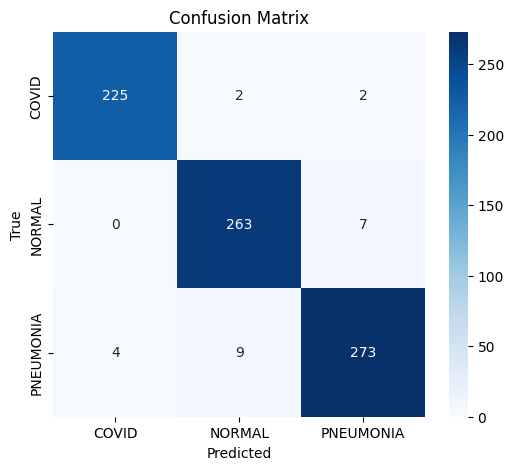

In [69]:
# Evaluating the trained model on the test dataset and printing performance metrics
evaluate_model(model, test_loader, class_names)


In [70]:
# Importing libraries for image processing, numerical operations, visualization, and tensor grid creation
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [71]:
# Defining a function that is applying Grad-CAM to visualize class-specific important regions
def apply_gradcam(model, image_tensor, target_class, layer_name='features.6'):
    # Setting the model to evaluation mode
    model.eval()

    # Adding batch dimension to the image and moving it to the selected device
    image_tensor = image_tensor.unsqueeze(0).to(device)

    gradients = []  # Storing gradients of the target layer
    activations = []  # Storing activations of the target layer

    # Defining a forward hook to capture activations
    def forward_hook(module, input, output):
        activations.append(output)

    # Defining a backward hook to capture gradients
    def full_backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Clearing any previously registered hooks to avoid conflicts
    for name, module in model.named_modules():
        if hasattr(module, "_backward_hooks"):
            module._backward_hooks.clear()
        if hasattr(module, "_forward_hooks"):
            module._forward_hooks.clear()
        if hasattr(module, "_forward_pre_hooks"):
            module._forward_pre_hooks.clear()

    # Registering hooks on the target convolutional layer
    target_layer = dict([*model.named_modules()])[layer_name]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(full_backward_hook)

    # Performing a forward pass and getting the class score of interest
    output = model(image_tensor)
    class_score = output[0, target_class]

    # Clearing previous gradients and performing backpropagation
    model.zero_grad()
    class_score.backward()

    # Extracting gradients and activations as numpy arrays
    grads = gradients[0].cpu().detach().numpy()[0]
    acts = activations[0].cpu().detach().numpy()[0]

    # Calculating average gradient (weights) for each channel
    weights = np.mean(grads, axis=(1, 2))

    # Initializing the Grad-CAM heatmap
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    # Performing a weighted combination of the activations using the gradients
    for i, w in enumerate(weights):
        cam += w * acts[i]

    # Applying ReLU to the CAM
    cam = np.maximum(cam, 0)

    # Resizing CAM to match the original image size
    cam = cv2.resize(cam, (224, 224))

    # Normalizing CAM to [0, 1]
    if np.max(cam) != 0:
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
    else:
        cam = np.zeros_like(cam)

    # Returning the final Grad-CAM heatmap
    return cam


In [72]:
# Defining a function that is displaying the Grad-CAM heatmap overlay for a specific image in the dataset
def show_gradcam(model, dataset, index, class_names):
    # Extracting the image and label at the given index from the dataset
    image, label = dataset[index]

    # Applying Grad-CAM to get the heatmap for the true class label
    cam = apply_gradcam(model, image, target_class=label)

    # Denormalizing the image for visualization (undoing normalization: x * std + mean)
    image_np = image.squeeze().numpy() * 0.5 + 0.5

    # Generating a colored heatmap from the Grad-CAM result
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Converting the single-channel grayscale image to a 3-channel format for overlaying
    image_np = np.stack([image_np] * 3, axis=2)

    # Creating an overlay by blending the image and the heatmap
    overlay = np.uint8(255 * (0.6 * image_np + 0.4 * heatmap / 255.0))

    # Plotting the overlay image with Grad-CAM visualization
    plt.figure(figsize=(6, 6))
    plt.title(f"Grad-CAM: {class_names[label]}")
    plt.imshow(overlay, cmap='gray')
    plt.axis('off')
    plt.show()


In [73]:
# Defining a function that is customizing a pretrained ResNet-50 model for grayscale image classification
def get_resnet50(num_classes=3):
    # Loading default pretrained weights for ResNet-50
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)

    # Replacing the first convolution layer to accept 1-channel grayscale input instead of 3-channel RGB
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Freezing all layers except for 'layer4' and the final fully connected (fc) layer
    for name, param in model.named_parameters():
        if not name.startswith("layer4") and not name.startswith("fc"):
            param.requires_grad = False  # Preventing updates during training

    # Replacing the final classification head with a custom fully connected block
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),  # Reducing dimensionality
        nn.ReLU(),  # Adding non-linearity
        nn.Dropout(0.4),  # Adding dropout for regularization
        nn.Linear(256, num_classes)  # Mapping to the target number of classes
    )

    # Returning the modified ResNet-50 model
    return model


In [74]:
# Creating the customized ResNet-50 model and moving it to the selected device (CPU or GPU)
resnet_model = get_resnet50(num_classes=3).to(device)


In [75]:
# Defining the loss function using weighted cross-entropy to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)

# Initializing the Adam optimizer and updating only the parameters of the final fully connected layer
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.0005)


In [92]:
# Training the customized ResNet-50 model using the training and validation data for 10 epochs
train_model(resnet_model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:38<00:00,  3.03it/s]


Train Loss: 0.0611 | Accuracy: 0.9784


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:35<00:00,  3.20it/s]


Train Loss: 0.0588 | Accuracy: 0.9809


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:38<00:00,  2.98it/s]


Train Loss: 0.0560 | Accuracy: 0.9787


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:37<00:00,  3.07it/s]


Train Loss: 0.0617 | Accuracy: 0.9770


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:37<00:00,  3.09it/s]


Train Loss: 0.0525 | Accuracy: 0.9825


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:38<00:00,  3.00it/s]


Train Loss: 0.0529 | Accuracy: 0.9828


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:36<00:00,  3.12it/s]


Train Loss: 0.0618 | Accuracy: 0.9787


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:36<00:00,  3.12it/s]


Train Loss: 0.0442 | Accuracy: 0.9858


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:37<00:00,  3.05it/s]


Train Loss: 0.0505 | Accuracy: 0.9822


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:37<00:00,  3.09it/s]

Train Loss: 0.0406 | Accuracy: 0.9852
Training complete.



Classification Report:

              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       229
      NORMAL       0.90      0.94      0.92       270
   PNEUMONIA       0.93      0.90      0.92       286

    accuracy                           0.93       785
   macro avg       0.94      0.94      0.94       785
weighted avg       0.93      0.93      0.93       785



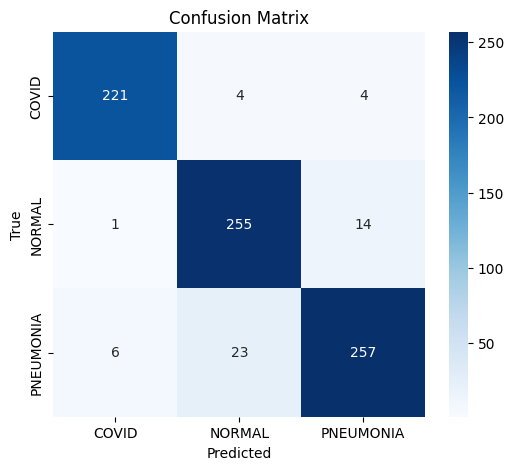

In [94]:
# Evaluating the trained ResNet-50 model on the test dataset and displaying classification metrics
evaluate_model(resnet_model, test_loader, class_names)


In [95]:
# Defining a function that is applying Grad-CAM to a ResNet model for visualizing important regions
def apply_gradcam_resnet(model, image_tensor, target_class, layer_name='layer4'):
    # Setting the model to evaluation mode
    model.eval()

    # Adding batch dimension and moving the image tensor to the selected device
    image_tensor = image_tensor.unsqueeze(0).to(device)

    gradients = []  # Storing gradients of the target layer
    activations = []  # Storing activations of the target layer

    # Getting the specified layer from the model
    target_layer = dict([*model.named_modules()])[layer_name]

    # Defining a forward hook that is capturing activations during the forward pass
    def forward_hook(module, input, output):
        activations.append(output)

    # Defining a backward hook that is capturing gradients during the backward pass
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Registering hooks to the target layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)

    try:
        # Performing the forward pass
        output = model(image_tensor)

        # Extracting the score of the target class
        class_score = output[0, target_class]

        # Performing the backward pass to compute gradients
        model.zero_grad()
        class_score.backward()

        # Checking if hooks successfully captured the data
        if not activations or not gradients:
            print("❌ Hooks failed. No activations or gradients captured.")
            return None

        # Extracting gradients and activations
        grads = gradients[0].cpu().detach().numpy()[0]
        acts = activations[0].cpu().detach().numpy()[0]

        # Calculating weights by averaging the gradients spatially
        weights = np.mean(grads, axis=(1, 2))

        # Creating the Grad-CAM heatmap by weighted combination of activation maps
        cam = np.zeros(acts.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * acts[i]

        # Applying ReLU to keep only positive contributions
        cam = np.maximum(cam, 0)

        # Resizing the heatmap to match the input image size
        cam = cv2.resize(cam, (224, 224))

        # Normalizing the heatmap
        if np.max(cam) != 0:
            cam = cam - np.min(cam)
            cam = cam / np.max(cam)
        else:
            cam = np.zeros_like(cam)

        # Returning the final Grad-CAM heatmap
        return cam

    finally:
        # Removing hooks to avoid memory leaks or duplicates
        forward_handle.remove()
        backward_handle.remove()


In [96]:
# Defining a function that is displaying the Grad-CAM heatmap overlay for a given sample from the dataset
def show_gradcam(model, dataset, index, class_names, is_resnet=False):
    # Extracting the image and corresponding label from the dataset at the specified index
    image, label = dataset[index]
    
    # Applying Grad-CAM based on the model architecture (ResNet or custom CNN)
    if is_resnet:
        cam = apply_gradcam_resnet(model, image, target_class=label)
    else:
        cam = apply_gradcam(model, image, target_class=label)

    # Denormalizing the image for visualization
    image_np = image.squeeze().numpy() * 0.5 + 0.5

    # Checking if Grad-CAM heatmap was successfully generated
    if cam is not None:
        # Creating a heatmap from the Grad-CAM result using OpenCV
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Converting grayscale image to 3-channel format
        image_np = np.stack([image_np] * 3, axis=2)

        # Creating an overlay by blending the original image and the heatmap
        overlay = np.uint8(255 * (0.6 * image_np + 0.4 * heatmap / 255.0))

        # Displaying the overlay with class name as title
        plt.figure(figsize=(6, 6))
        plt.title(f"Grad-CAM: {class_names[label]}")
        plt.imshow(overlay)
        plt.axis('off')
        plt.show()
    else:
        # Printing a warning if Grad-CAM failed
        print("⚠️ Grad-CAM failed or returned None.")


In [97]:
# Defining a function that is saving the Grad-CAM heatmap overlay as an image file
def save_gradcam_image(model, dataset, index, class_names, save_dir="gradcam_outputs"):
    
    # Getting the original image path and label using the dataset indices
    img_path, label = dataset.dataset.samples[dataset.indices[index]]

    # Importing PIL and opening the image in grayscale mode
    from PIL import Image
    image = Image.open(img_path).convert("L")  # Converting to grayscale explicitly

    # Applying the validation/test transformations to the image
    image_tensor = val_test_transforms(image)

    # Applying Grad-CAM to get the heatmap for the selected image and class
    cam = apply_gradcam_resnet(model, image_tensor, target_class=label)

    # Denormalizing and converting the tensor to a 3-channel image
    image_np = image_tensor.squeeze().numpy() * 0.5 + 0.5
    image_np = np.stack([image_np] * 3, axis=2)

    # Checking if CAM was generated successfully
    if cam is not None:
        # Creating and formatting the Grad-CAM heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Creating an overlay of the original image and the heatmap
        overlay = np.uint8(255 * (0.6 * image_np + 0.4 * heatmap / 255.0))

        # Creating the output directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)

        # Defining the output filename using class name and index
        filename = f"{save_dir}/{class_names[label]}_index{index}.png"

        # Saving the overlay image to disk
        cv2.imwrite(filename, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        print(f"✅ Saved: {filename}")
    else:
        # Printing a warning if CAM generation failed
        print(f"⚠️ CAM failed for index {index}")


In [98]:
# Initializing a set to keep track of which class labels have already been saved
saved_labels = set()

# Iterating through the test dataset
for i in range(len(test_dataset)):
    # Getting the image and its corresponding label
    _, label = test_dataset[i]

    # Checking if the label has not already been saved
    if label not in saved_labels:
        # Saving the Grad-CAM overlay image for the current sample
        save_gradcam_image(resnet_model, test_dataset, i, class_names)

        # Adding the label to the set of saved labels
        saved_labels.add(label)

    # Breaking the loop once one image per class has been saved
    if len(saved_labels) == len(class_names):
        break


✅ Saved: gradcam_outputs/COVID_index0.png
✅ Saved: gradcam_outputs/PNEUMONIA_index1.png
✅ Saved: gradcam_outputs/NORMAL_index7.png


In [99]:
# Setting the path to the external test dataset directory
external_test_dir = "/home/campus10/ckota/Downloads/external/Data/test"


In [100]:
# Importing necessary modules for dataset loading
from torchvision import datasets
from torch.utils.data import DataLoader

# Loading the external test dataset using ImageFolder and applying validation/test transformations
external_dataset = datasets.ImageFolder(
    external_test_dir,
    transform=val_test_transforms 
)

# Creating a DataLoader for the external dataset without shuffling
external_loader = DataLoader(
    external_dataset,
    batch_size=32,
    shuffle=False
)

# Extracting and printing the class names from the external dataset
external_class_names = external_dataset.classes
print("External class names:", external_class_names)

# Printing the total number of samples in the external dataset
print("Total samples:", len(external_dataset))


External class names: ['COVID19', 'NORMAL', 'PNEUMONIA']
Total samples: 1288


In [102]:
# Accessing and assigning the last convolutional block (layer4) of the ResNet model for Grad-CAM
target_layer = resnet_model.layer4



Classification Report:

              precision    recall  f1-score   support

     COVID19       0.91      0.96      0.93       116
      NORMAL       0.82      0.91      0.87       317
   PNEUMONIA       0.96      0.92      0.94       855

    accuracy                           0.92      1288
   macro avg       0.90      0.93      0.91      1288
weighted avg       0.92      0.92      0.92      1288



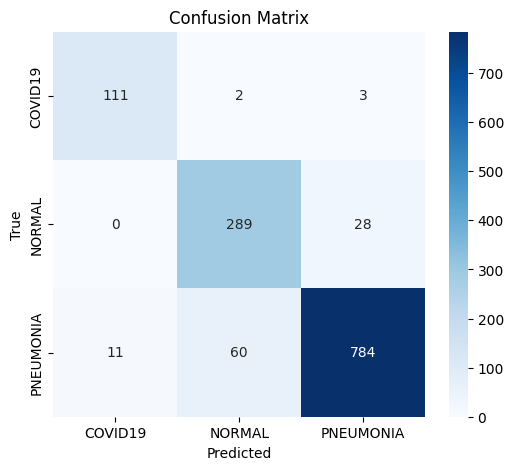

In [101]:
# Evaluating the trained ResNet-50 model on the external test dataset and displaying classification metrics
evaluate_model(resnet_model, external_loader, external_class_names)


Saving Grad-CAM for class: COVID


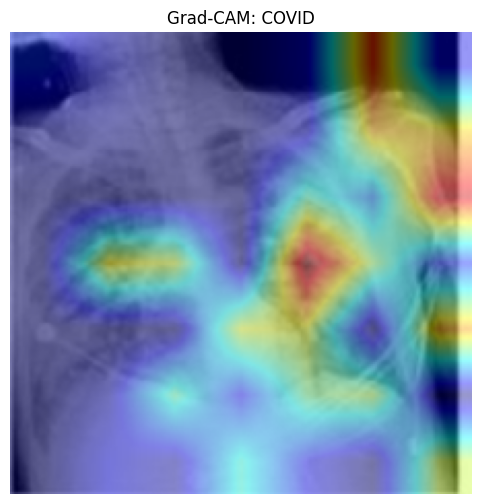

Saving Grad-CAM for class: PNEUMONIA


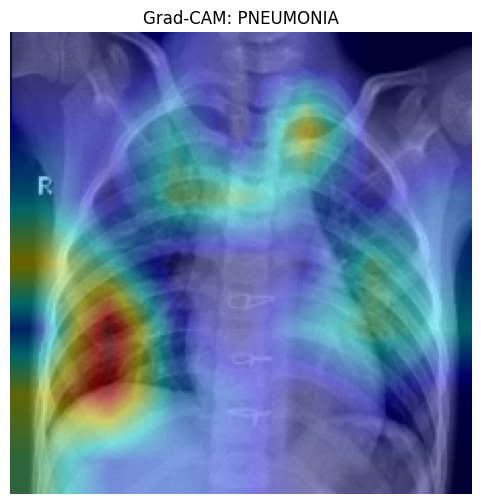

Saving Grad-CAM for class: NORMAL


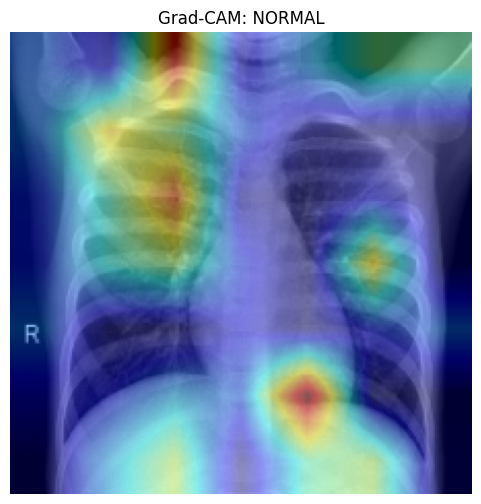

In [88]:
# Initializing a set to keep track of classes for which Grad-CAMs are already saved
saved_labels = set()

# Iterating over each sample in the test dataset
for i in range(len(test_dataset)):
    # Getting the image and true label at the current index
    image, label = test_dataset[i]

    # Getting the model's predicted label by running inference
    pred = resnet_model(image.unsqueeze(0).to(device)).argmax().item()
    
    # Checking if the prediction is correct and the class hasn't been visualized yet
    if pred == label and label not in saved_labels:
        print(f"Saving Grad-CAM for class: {class_names[label]}")

        # Displaying the Grad-CAM visualization for this correctly predicted sample
        show_gradcam(resnet_model, test_dataset, i, class_names, is_resnet=True)

        # Adding the label to the set of saved classes
        saved_labels.add(label)
    
    # Breaking the loop once all classes have been visualized once
    if len(saved_labels) == len(class_names):
        break


In [89]:
# Defining a function that is saving Grad-CAM visualizations for misclassified samples
def show_gradcam_misclassified(model, dataset, class_names, is_resnet=True, save_dir="gradcam_outputs_misclassified"):
    # Creating the output directory if it does not already exist
    os.makedirs(save_dir, exist_ok=True)

    # Initializing a set to keep track of already saved (true, predicted) label pairs
    saved = set()

    # Iterating through the dataset
    for i in range(len(dataset)):
        # Extracting the image and its true label
        image, true_label = dataset[i]

        # Preparing the image tensor for model inference
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)

        # Getting the predicted label
        pred_label = output.argmax().item()

        # Checking if the prediction is incorrect and this misclassification type is not already saved
        if pred_label != true_label and (true_label, pred_label) not in saved:
            # Applying Grad-CAM for the true label using the appropriate method
            cam = apply_gradcam_resnet(model, image, target_class=true_label) if is_resnet else apply_gradcam(model, image, target_class=true_label)

            # Denormalizing the image for visualization
            image_np = image.squeeze().numpy() * 0.5 + 0.5
            image_np = np.stack([image_np] * 3, axis=2)

            # Checking if the Grad-CAM output is valid
            if cam is not None:
                # Creating the Grad-CAM heatmap and overlay
                heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
                overlay = np.uint8(255 * (0.6 * image_np + 0.4 * heatmap / 255.0))

                # Constructing the filename and saving the image
                fname = f"{class_names[true_label]}_as_{class_names[pred_label]}_index{i}.png"
                save_path = os.path.join(save_dir, fname)
                cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

                print(f"❌ Saved misclassified Grad-CAM: {fname}")

                # Recording that this misclassification pair has been saved
                saved.add((true_label, pred_label))

        # Limiting to 3 misclassified examples (can be adjusted)
        if len(saved) >= 3:  
            break


In [93]:
show_gradcam_misclassified(resnet_model, test_dataset, class_names, is_resnet=True)


❌ Saved misclassified Grad-CAM: COVID_as_PNEUMONIA_index0.png
❌ Saved misclassified Grad-CAM: PNEUMONIA_as_COVID_index2.png
❌ Saved misclassified Grad-CAM: NORMAL_as_PNEUMONIA_index49.png
